# Introduction

This sample notebook takes you through an end-to-end workflow to demonstrate the functionality of SageMaker Ground Truth. We'll leverage SageMaker core functionality along with Ground Truth to train and deploy a basic facial recognition model. In our Ground Truth labelling job, we'll present our labelers with a pair of photos and ask them to identify if the faces in photos are of the same or different person. We'll then train a siamese network model that given two face photos as inputs, will be able to tell us if these are of the same person.

### Datasets Used
Rather than splitting a single set of facial images, we'll use two completely distinct facial image datasets for training and evaluating the model
- Model Training: [AT&T Database of Faces](https://www.kaggle.com/kasikrit/att-database-of-faces)
- Model Evaluation: [Yale Face Database](https://www.kaggle.com/olgabelitskaya/yale-face-database)



In [1]:
import boto3
from sagemaker import get_execution_role
import sagemaker
import os
from glob import glob
import random
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt
from sagemaker.tensorflow import TensorFlow

%matplotlib inline

In [24]:
# We'll use the default role for data access and job execution
role = get_execution_role()

# Manage interactions with the Amazon SageMaker APIs and any other AWS services needed.
sess = sagemaker.Session()
sm_client = sess.boto_session.client('sagemaker')

# uses a default bucket created by sagemaker
bucket = sess.default_bucket()

# Region of our account
region = sess.boto_region_name

# name of our labeling job
labeling_job_name = "face-labeling"

# path to where we'll copy all of the data
s3_root_path = os.path.join("s3://", bucket, "ground_truth_lab")

# path to data that we'll use in our Ground Truth Labeling Job
job_data_path = os.path.join(s3_root_path, "face_labeling_job_images")

# path to configuration files we'd need to setup our labeling job via SDK
labeling_job_config_path = os.path.join(s3_root_path, "gt_config")

# path to data that's already been labeled
labeled_data_path = os.path.join(s3_root_path, "labeled")

# Ground Truth lambda ARNs - needed to setup job through SDK
pre_annotation_lambdas = {"us-east-1": "arn:aws:lambda:us-east-1:432418664414:function:PRE-ImageMultiClass", 
                  "us-east-2": "arn:aws:lambda:us-east-2:266458841044:function:PRE-ImageMultiClass"}

consolidation_lambdas = {"us-east-1":"arn:aws:lambda:us-east-1:432418664414:function:ACS-ImageMultiClass", 
                 "us-east-2": "arn:aws:lambda:us-east-2:266458841044:function:ACS-ImageMultiClass"}


In [17]:
#First we create a manifest files which contains the s3 paths to the images we wish to annotate
with open("gt_config/input.manifest", "w") as f:
    images = glob("face_labeling_job_images/*.png")
    for image in images:
        s3_ref = {"source-ref":os.path.join(s3_root_path, image)}
        f.write(f"{json.dumps(s3_ref)}\n")

In [19]:
# next we upload the image data to S3
!aws s3 cp labeled {labeled_data_path} --recursive --quiet
!aws s3 cp face_labeling_job_images {job_data_path} --recursive --quiet
!aws s3 cp gt_config {labeling_job_config_path} --recursive --quiet

# Setup a Ground Truth Labeling Job
#### We'll use a private team to avoid any charges and get a better feel for the labeling user experience. First we need to setup a private team. Please follow the steps below:
1. Find the SageMaker Service in the AWS Management Console 
<img src="./notebook_images/LJ1.JPG">

2. In the SageMaker console under Ground Truth, click **Labeling workforces**
<img src="notebook_images/LT1.JPG">

3. Click **Private**
4. Click **Create private team**
5. Name your team **test-team** and provide your email address for both worker and contact. Fill out the rest as per below
<img src="notebook_images/LT4.PNG">

In [12]:
workteams = sm_client.list_workteams()["Workteams"]
team_arn = [wt["WorkteamArn"] for wt in workteams if wt["WorkteamName"] == "test-team"][0]

In [27]:
resp = sm_client.create_labeling_job(
    LabelingJobName=f"{labeling_job_name}",
    LabelAttributeName=f"{labeling_job_name}",
    InputConfig={
        "DataSource": {
            "S3DataSource": {
                "ManifestS3Uri": f"{labeling_job_config_path}/input.manifest"
            }
        },
    },
    OutputConfig={
        "S3OutputPath": f"{labeled_data_path}",
    },
    RoleArn=f"{role}",
    LabelCategoryConfigS3Uri=f"{labeling_job_config_path}/label_config.json",
    StoppingConditions={
        "MaxHumanLabeledObjectCount": 200,
        "MaxPercentageOfInputDatasetLabeled": 100
    },

    HumanTaskConfig={
        "WorkteamArn": f"{team_arn}",
        "UiConfig": {
            "UiTemplateS3Uri": f"{labeling_job_config_path}/template.liquid"
        },
        "PreHumanTaskLambdaArn": f"{pre_annotation_lambdas[region]}",
        "TaskTitle": "ground truth lab",
        "TaskDescription": "facial recognition",
        "NumberOfHumanWorkersPerDataObject": 1,
        "TaskTimeLimitInSeconds": 240,
        "TaskAvailabilityLifetimeInSeconds": 240,
        "MaxConcurrentTaskCount": 200,
        "AnnotationConsolidationConfig": {
            "AnnotationConsolidationLambdaArn": f"{consolidation_lambdas[region]}"
        },

    },
)

# Model Training
Now that we have a nice labeled dataset to work with. We can begin training our model

We'll train a model emloying a Siamese network architecture where we pass in two images as inputs and the model attempts to minimize the distance based loss function to bring similar images together and push dissimilar images appart

<img src="notebook_images/siamese_network.jpg" width=600>

[Dimensionality Reduction by Learning an Invariant Mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)

In [28]:
#We'll build our model with Tensorflow. SageMaker has a managed container that can be used to run managed training jobs.
#To run a training job with Sagemaker, you just need to provide a script that trains the model and saves a the model artifact to a specified directory
#Let's take a look at the script
!pygmentize -l python src/training.py

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
import numpy as np
import os
import json
import argparse


def load_and_split(path, label):
    
    """Loads and splits the image and returns a tuple of image pair and label
    
    Parameters
    ----------
    path : str
        The location of the paired image
    label : int,
        Inidcates whether the images are different(0) or same(1) 

    Returns
    -------
    tuple[tuple[Tensor[float]], Tensor[float]]
        a tuple of image pairs and the label
    """

    tf_path = tf.strings.join([f"{os.environ.get('SM_CHANNEL_TRAINING')}/", path])
    
    image = tf.io.read_file(tf_path)
    image = tf.image.decode_png(image, channels=1)
    image /= 255
    image1, image2 = image[:,:92,:], image[:,93:,:]
    
    return (image1, image2), float(labe

In [45]:
#set up the training job
model = TensorFlow(entry_point='src/training.py',
                             role=role,
                             train_instance_count=1,
                             train_instance_type='local_gpu',
                             framework_version='2.1.0',
                             py_version='py3',
                             hyperparameters = {"epochs": 20, "steps_per_epoch":32}
                      )

In [46]:
#fit model on the labeled data
model.fit(inputs=labeled_data_path)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Creating tmphdsgqunh_algo-1-w4bq2_1 ... 
Attaching to tmphdsgqunh_algo-1-w4bq2_12mdone
algo-1-w4bq2_1  | 2020-08-12 20:43:01,853 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-w4bq2_1  | 2020-08-12 20:43:02,126 sagemaker-containers INFO     Invoking user script
algo-1-w4bq2_1  | 
algo-1-w4bq2_1  | Training Env:
algo-1-w4bq2_1  | 
algo-1-w4bq2_1  | {
algo-1-w4bq2_1  |     "additional_framework_parameters": {},
algo-1-w4bq2_1  |     "channel_input_dirs": {
algo-1-w4bq2_1  |         "training": "/opt/ml/input/data/training"
algo-1-w4bq2_1  |     },
algo-1-w4bq2_1  |     "current_host": "algo-1-w4bq2",
algo-1-w4bq2_1  |     "framework_module": "sagemaker_tensorflow_container.training:main",
algo-1-w4bq2_1  |     "hosts": [
algo-1-w4bq2_1  |         "algo-1-w4bq2"
algo-1-w4bq2_1  |     ],
algo-1-w4bq2_1  |     "hyperparameters": {
algo-1-w4bq2_1  |         "epochs": 20,
algo-1-w4bq2_1  |         "steps_per_epoch": 32,
algo-1-w4bq2_1  |       

In [47]:
predictor = model.deploy(initial_instance_count=1, instance_type='local')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Attaching to tmpml8joj___algo-1-96nrd_1
algo-1-96nrd_1  | INFO:__main__:starting services
algo-1-96nrd_1  | INFO:__main__:using default model name: model
algo-1-96nrd_1  | INFO:__main__:tensorflow serving model config: 
algo-1-96nrd_1  | model_config_list: {
algo-1-96nrd_1  |   config: {
algo-1-96nrd_1  |     name: "model",
algo-1-96nrd_1  |     base_path: "/opt/ml/model",
algo-1-96nrd_1  |     model_platform: "tensorflow"
algo-1-96nrd_1  |   }
algo-1-96nrd_1  | }
algo-1-96nrd_1  | 
algo-1-96nrd_1  | 
algo-1-96nrd_1  | INFO:__main__:nginx config: 
algo-1-96nrd_1  | load_module modules/ngx_http_js_module.so;
algo-1-96nrd_1  | 
algo-1-96nrd_1  | worker_processes auto;
algo-1-96nrd_1  | daemon off;
algo-1-96nrd_1  | pid /tmp/nginx.pid;
algo-1-96nrd_1  | error_log  /dev/stderr info;
algo-1-96nrd_1  | 
algo-1-96nrd_1  | worker_rlimit_nofile 4096;
algo-1-96nrd_1  | 
algo-1-96nrd_1  | events {
algo-1-96nrd_1  |   worker_connections 2048;
algo-1-96nrd_1  | }
algo-1-96nrd_1  | 
algo-1-96nrd_1  

In [32]:
def prep_image(path):
    
    im = Image.open(path)
    im = np.array(im)
    im = im[:, (im != 255).sum(axis=0) > 50]
    im = np.array(Image.fromarray(im).resize((92,112)))
    im = im / 255
    return im[None,:,:,None]

algo-1-xy9fp_1  | 2020/08/12 20:40:29 [info] 14#14: *1 client 172.18.0.1 closed keepalive connection


In [33]:
def show_output(f1_sub, f1_expr, f2_sub, f2_expr, thresh=0.5):
    
    path1 = f"test_images/{f1_sub}.{f1_expr}"
    path2 = f"test_images/{f2_sub}.{f2_expr}"
    
    im1 = prep_image(path1)
    im2 = prep_image(path2)
    
    inputs = {
      'instances': [
        {"input_top":im1.tolist(),
        "input_bottom":im2.tolist()},
      ]
    }
    
    prediction = predictor.predict(inputs)['predictions'][0][0]
    
    img1 = Image.open(path1)
    img2 = Image.open(path2)
    
    fig, axes = plt.subplots(1, 2, figsize=(10,7))
    axes[0].imshow(img1, cmap='gray')
    axes[1].imshow(img2, cmap='gray')
    
    for ax in axes:
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    
    same_dif = "same" if prediction < thresh else "different"
    
    fig.suptitle(f"Dissimilarity Score = {prediction:.3f}\n Likely {same_dif} person", y=0.85, size=20)
    plt.tight_layout()

In [34]:
expressions = ['surprised', 'sleepy', 'glasses', 'normal', 
               'sad', 'wink', 'centerlight', 'happy', 'noglasses']

subjects = [f"subject{x:02d}" for x in range(1,16)]

algo-1-96nrd_1  | 172.18.0.1 - - [12/Aug/2020:20:45:38 +0000] "POST /invocations HTTP/1.1" 200 43 "-" "-"


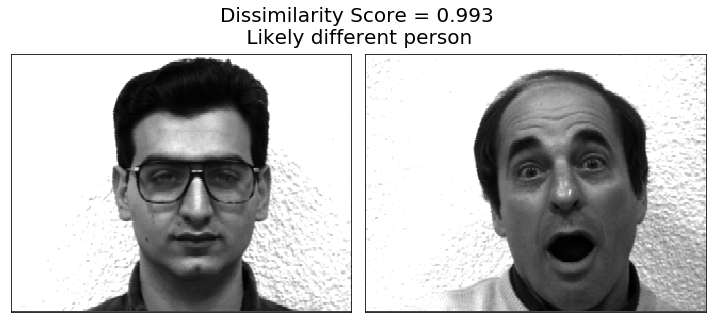

In [60]:
show_output(f1_sub = random.choice(subjects), f1_expr = random.choice(expressions),
           f2_sub = random.choice(subjects), f2_expr = random.choice(expressions))

algo-1-96nrd_1  | 172.18.0.1 - - [12/Aug/2020:20:46:12 +0000] "POST /invocations HTTP/1.1" 200 43 "-" "-"


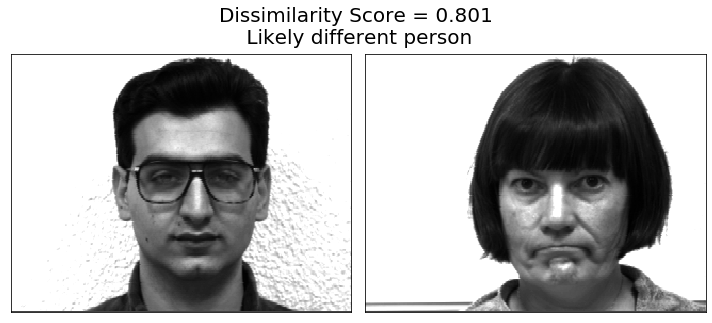

In [65]:
show_output(f1_sub = subjects[14], f1_expr = expressions[2],
           f2_sub = subjects[10], f2_expr = expressions[4])

In [44]:
#delete the endpoint 
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)
